In [8]:
.libPaths(R.home('/opt/homebrew/Caskroom/miniforge/base/lib/R/library'))
Output = '/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1013. Microbiome Peanut Allergy/P1013.3. Analyses/P1013.3.3. Volcano Plots/Output'
cur_date = '090825'

library(readxl)
library(openxlsx)
library(writexl)
library(tidyverse)
library(ggrepel)

# reading in files
bl_saliva_adj = data.frame(Model = 'Saliva BL Outcome', read_excel("Input/Saliva_Adj_Outcome_090825.xlsx"))
bl_stool_adj = data.frame(Model = 'Stool BL Outcome', read_excel("Input/Stool_Adj_Outcome_090825.xlsx"))

In [9]:
head(bl_saliva_adj)

,Model,Name,Name1,logFC,P.Value,P.Adj,Sensitivity.Analysis,diff_robust_OutcomeSU
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
1,Saliva BL Outcome,k__Bacteria.__.__.__.__.__.__,Unassigned,0.29178065,0.462788934,0.85366752,TRUE,FALSE
2,Saliva BL Outcome,k__Bacteria.p__Absconditabacteria_.SR1..c__Absconditabacteria_.SR1._.C.1..o__Absconditabacteria_.SR1._.O.1..f__Absconditabacteria_.SR1._.F.1.,Absconditabacteria_.SR1._.G.1. bacterium_HMT_874,0.76969087,0.054463067,0.24508380,TRUE,FALSE
3,Saliva BL Outcome,k__Bacteria.p__Absconditabacteria_.SR1..c__Absconditabacteria_.SR1._.C.1..o__Absconditabacteria_.SR1._.O.1..f__Absconditabacteria_.SR1._.F.1.,Absconditabacteria_.SR1._.G.1. bacterium_HMT_875,12.06030124,1.000000000,1.00000000,TRUE,FALSE
4,Saliva BL Outcome,k__Bacteria.p__Actinobacteria.c__Actinomycetia.o__Actinomycetales.f__Actinomycetaceae,Actinomyces,0.07289551,0.882512576,1.00000000,TRUE,FALSE
5,Saliva BL Outcome,k__Bacteria.p__Actinobacteria.c__Actinomycetia.o__Actinomycetales.f__Actinomycetaceae,Actinomyces graevenitzii,-1.67165466,0.007295550,0.08535793,TRUE,FALSE
6,Saliva BL Outcome,k__Bacteria.p__Actinobacteria.c__Actinomycetia.o__Actinomycetales.f__Actinomycetaceae,Schaalia lingnae,-0.90445448,0.004158115,0.06644521,TRUE,FALSE


Creating a volcano plot to visualize bacteria that were differentially abundant.

In [11]:
# combining dfs
baseline_adj_df = rbind(bl_saliva_adj, bl_stool_adj)

In [12]:
get_significance = function(df){
    # adding a col to denote whether a Name1 had a significant p value, log FC, or both
    
    # add a column of NAs
    df$diffexpressed <- "No Significance"
    
    # if p adj is significant only
    df$diffexpressed[df$P.Adj < 0.1] <- "P Adjust Only"
    
    # if logFoldChange > log(1.5)? and p adj < 0.01, set as "significant" 
    df$diffexpressed[abs(df$logFC) > abs(log(1.5)) & df$P.Adj < 0.1] <- "P Adjust and log Fold Change"
    
    # making into a factor
    df$diffexpressed = factor(df$diffexpressed, levels = c("No Significance", "P Adjust Only", 
                                                                           "P Adjust and log Fold Change"))

    return(df)
}

# calling fn
sig_baseline_adj_df = get_significance(baseline_adj_df)

In [84]:
# identifying genes commonly modulated across exposure groups to label them differently
sig_bl_saliva_bacteria = sig_baseline_adj_df %>%
    filter(Model == 'Saliva BL Outcome', diffexpressed == "P Adjust and log Fold Change") %>%
    select(Name1) %>% pull()

sig_bl_stool_bacteria = sig_baseline_adj_df %>%
    filter(Model == 'Stool BL Outcome', diffexpressed == "P Adjust and log Fold Change") %>%
    select(Name1) %>% pull()

`%notin%` <- Negate(`%in%`)

common_bacteria = intersect(sig_bl_saliva_bacteria, sig_bl_stool_bacteria)
uncommon_boolean = c(sig_bl_saliva_bacteria, sig_bl_stool_bacteria) %notin% common_bacteria
uncommon_bacteria = c(sig_bl_saliva_bacteria, sig_bl_stool_bacteria)[uncommon_boolean]

# Volcano Plot

Warning message:
“Removed 36 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


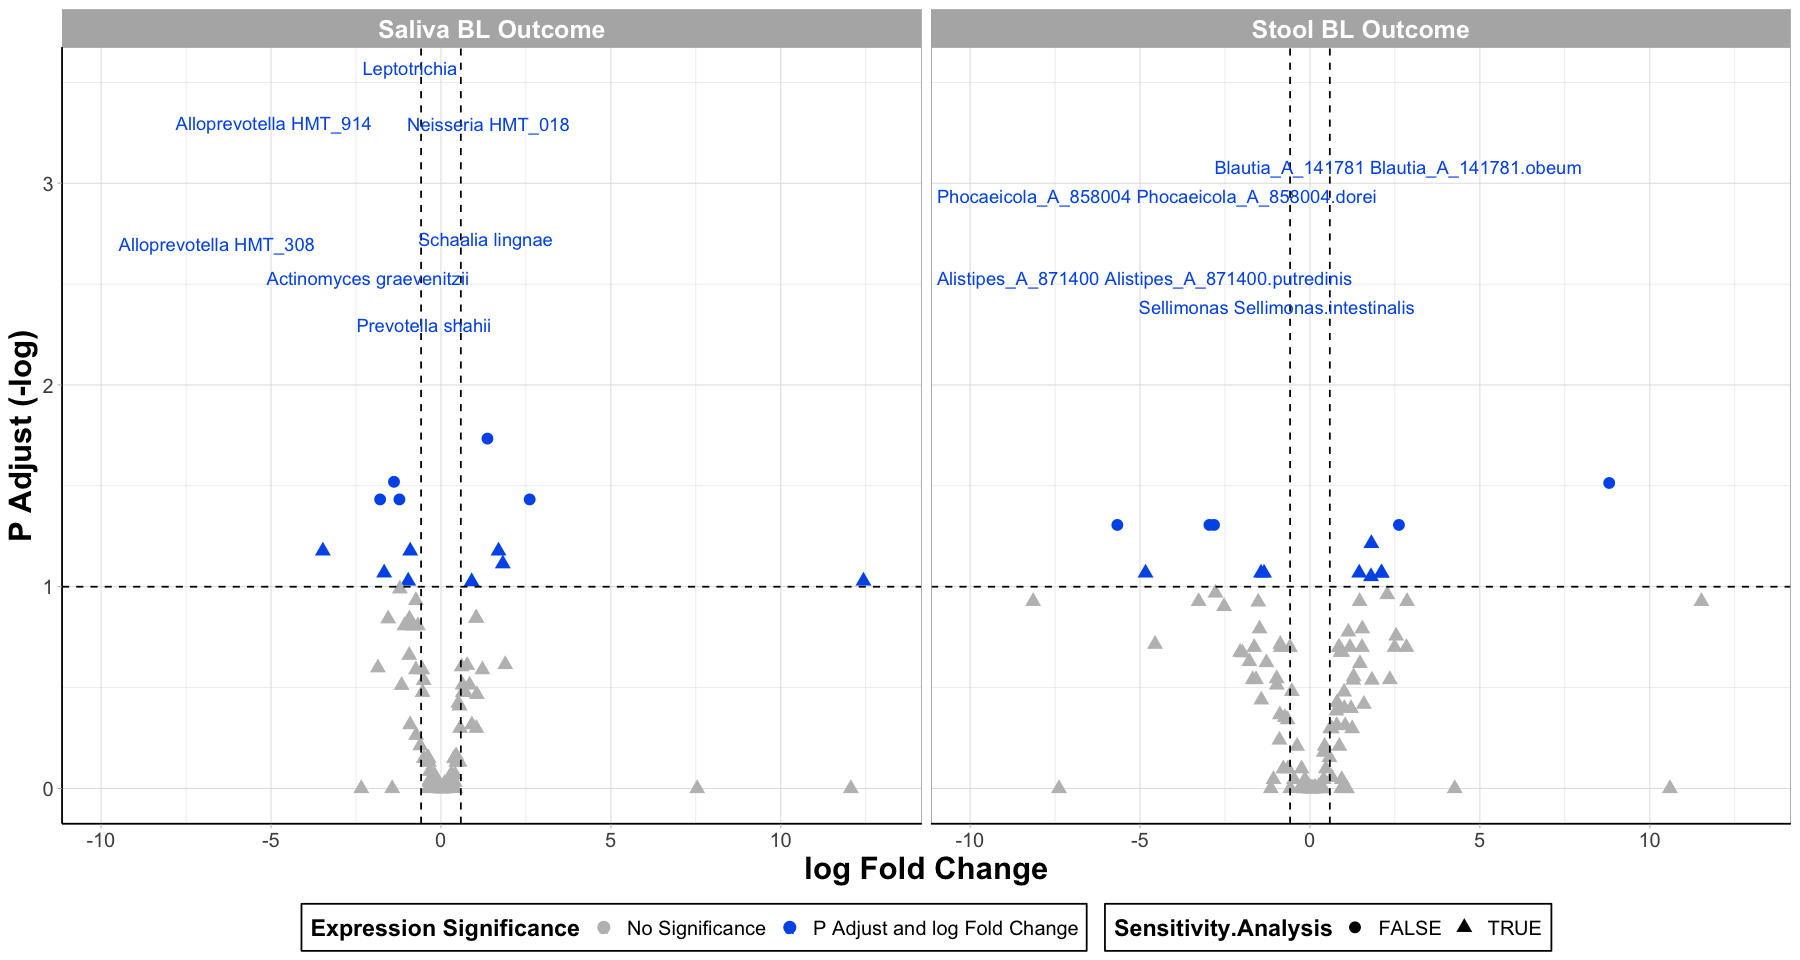

In [108]:
options(repr.plot.width=15, repr.plot.height=8) #changing size

ggplot() + 
  geom_point(data = sig_baseline_adj_df, aes(x = logFC, y = -log10(P.Adj), color = diffexpressed,
                             shape = Sensitivity.Analysis), size = 3) + 

  # P Value line
  geom_hline(yintercept = -log10(0.1), linetype = "dashed") + 
  # FC Line
  geom_vline(xintercept = log2(1.5), linetype = "dashed") +
  geom_vline(xintercept = -log2(1.5), linetype = "dashed") +

  # changing x limits of what is visible in the plot
    xlim(-10, 13) + 
  # ylim(0, 3) + 

 #labeling points with statistical significance and FC
  # geom_label_repel(data = sig_baseline_adj_df %>%
  #                 filter(logFC > log(1.5), Name1 %in% common_genes_df$Name1), 
  #                  aes(x = logFC, y = -log10(P.Adj), label = Name1, color = diffexpressed),
  #                 xlim = c(1.5, NA), hjust = 0, segment.size = 0.3, max.overlaps = Inf, size = 5, show.legend = FALSE, parse = TRUE) + 

  # geom_text_repel(data = sig_baseline_adj_df %>%
  #                 filter(logFC > log(1.5), Name1 %in% uncommon_bacteria), 
  #                 aes(x = logFC, y = -log(P.Adj), label = Name1, color = diffexpressed), xlim = c(1.3, NA), hjust = 0, 
  #                 segment.size = 0.3, box.padding = 1, max.overlaps = Inf, size = 4.2, show.legend = FALSE, nudge_y = 0) + 

  geom_text_repel(data = sig_baseline_adj_df %>%
                  filter(logFC < -log(1.5), Name1 %in% uncommon_bacteria), 
                 aes(x = logFC, y = -log(P.Adj), label = Name1, color = diffexpressed)#, #xlim = c(-4, NA), 
                  #hjust = 'left', #direction = 'y',
                 #segment.size = 0.3, box.padding = 1, max.overlaps = Inf, size = 4.2, show.legend = FALSE#, nudge_y = 0.8
                 ) + 

  facet_wrap(~Model, scales = 'free_x') + 

  theme_light() + 
  theme(axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 14), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", # changing legend position
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        strip.text.x = element_text(size = 15, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 15, face = "bold")) + #changes size of facet y axis 
  labs(x = 'log Fold Change', y = 'P Adjust (-log)') +

  scale_color_manual(name = "Expression Significance",
                      values = c("gray", "#005BEA", '#F0D25E'))